## Extract Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/training data/Training and Validation Data_2023_T1_COMP3010.zip' -d training

In [ ]:
!unzip '/content/drive/MyDrive/training data/Testing Data_Dubai_2023.zip' -d test

In [ ]:
#!rmdir '/content/training/Data/coral image classification/train/.ipynb_checkpoints'

## Load Libraries

In [ ]:
## Python Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
import numpy as np

## Neural Network
import torch as tr
import torchvision.datasets as datasets
from torchvision import models
import torchvision.transforms as trnsform
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from pylab import *

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Check Tourch Version

In [ ]:
print("Using torch", tr.__version__)

Using torch 1.13.1+cu116


## Checking Cuda Support (GPU)

In [ ]:
print(tr.cuda.device_count())
print(tr.cuda.get_device_name(0))

1
Tesla T4


#Assign cuda GPU located at location '0' to a variable


In [ ]:
cuda0 = tr.device('cuda:0')
cuda0

device(type='cuda', index=0)

## Seed Settings

In [ ]:
tr.cuda.manual_seed(1)
tr.backends.cudnn.deterministic = True
tr.backends.cudnn.benchmark = False

## Load Dataset

In [ ]:
# ToTenssor, Convert Image into Pixel of Range [0,255] and images are normalized.
transform = trnsform.Compose([trnsform.Resize(255),trnsform.CenterCrop(224),trnsform.ToTensor()])

traindata = datasets.ImageFolder(root='/content/training/Data/coral image classification/train',transform=transform)
# Val Data
valdata = datasets.ImageFolder(root='/content/training/Data/coral image classification/val',transform=transform)
## Test Data
testdata = datasets.ImageFolder(root='/content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification',transform=transform)

## Train Data

* Train Data has 1117 Datapoints

In [ ]:
traindata

Dataset ImageFolder
    Number of datapoints: 1117
    Root location: /content/training/Data/coral image classification/train
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Val Data

* Val Data has 400 Datapoints

In [ ]:
valdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/training/Data/coral image classification/val
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Test Data

* Test Data has 400 Datapoints

In [ ]:
testdata

Dataset ImageFolder
    Number of datapoints: 400
    Root location: /content/test/Testing Data_2023/Testing Data_withLabels/CoralImageClassification
    StandardTransform
Transform: Compose(
               Resize(size=255, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
           )

## Classes of Dataset

In [ ]:
classes=traindata.classes
classes

['Coral Images', 'Non-Coral Images']

## Loading Data From Images into Varaibles

In [ ]:
X_trian = tr.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
X_test = tr.utils.data.DataLoader(testdata, batch_size=32, shuffle=True)
X_val = tr.utils.data.DataLoader(valdata, batch_size=32, shuffle=True)

## Printing Batch and Labels size

In [ ]:
batch, labels = next(iter(X_trian))

In [ ]:
print("Batch size", batch.size()[0])
print("Image size", batch.size()[2],"x",batch.size()[3])
print("Image Channel", batch.size()[1])
print("Label size,", labels.size())

Batch size 32
Image size 224 x 224
Image Channel 3
Label size, torch.Size([32])


## Ploting Images

In [ ]:
def functionlabel(label):
  if label == 1:
    return 'Coral Image'
  else:
    return 'Non-Coral Image'

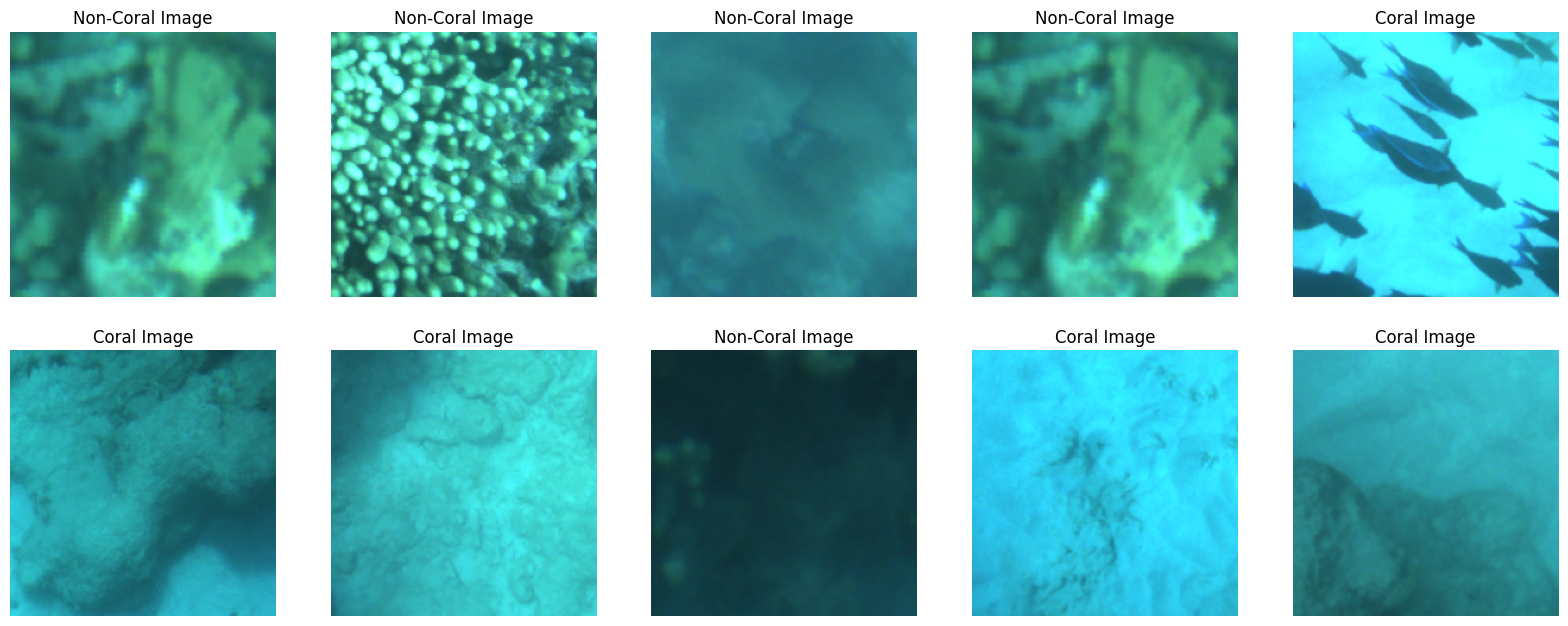

In [ ]:
plt.figure(figsize=(20,20))
for n , i in enumerate(list(np.random.randint(0,len(batch),10))) : 
    plt.subplot(5,5,n+1)
    plt.imshow(batch[i].T)
    plt.title(functionlabel(labels[i]))
    plt.axis('off')     
plt.show()

## Labels

In [ ]:
y_train = np.array([y for x, y in iter(traindata)])
y_test = np.array([y for x, y in iter(testdata)])
y_val = np.array([y for x, y in iter(valdata)])

## Training Count

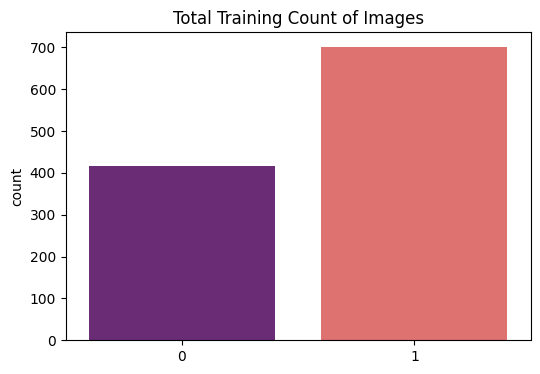

In [ ]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Training Count of Images')
sns.countplot(x = y_train, palette = 'magma')
plt.show()

## Test Count

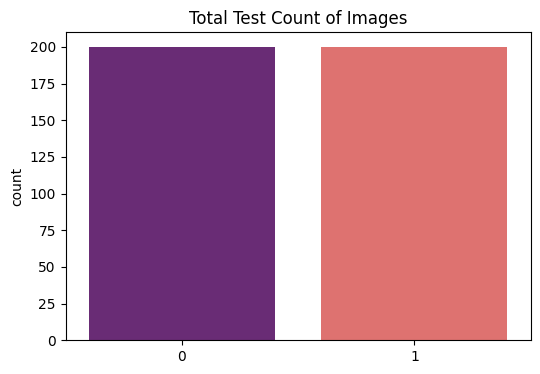

In [ ]:
f, ax = plt.subplots(figsize = (6,4))
plt.title('Total Test Count of Images')
sns.countplot(x = y_test, palette = 'magma')
plt.show()

## Creating Model Scratch

## Ouput Size Formula

* (((I - K + 2P)/S) + 1)

#### Where 
* I is Input size
* K is kernel size
* P is padding 
* S is Stride 

So, For this Problem Output Size for each layer will be

* Conv 1 = (224-3 + 2(0))/1) + 1 = 222
* Maxpool = 222/2 = 111 (Since K =2 , Stride= 2) it halfs the image
* Conv 2 =  ((111 - 3 + 2(0))/1) + 1 = 109
* Maxpool = 109/2 = 54 (Since K =2 , Stride= 2) it halfs the image
* Conv 3 =  ((54 - 3 + 2(0))/1) + 1 = 52
* Maxpool = 52/2 = 26 (Since K =2 , Stride= 2) it halfs the image
* Conv 4 =  ((26 - 3 + 2(0))/1) + 1 = 24
* Maxpool = 24/2 = 12 (Since K =2 , Stride= 2) it halfs the image

* Final Output size = 12
* FLatten = 256 * 12 * 12 = 36,864 (where 256 is final convulation layer output neurons)

In [ ]:
class CoralNet(nn.Module):
    
    # CNN Model
    def __init__(self):
        
        super(CoralNet, self).__init__()
        # Convolution Layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        
        # FC size
        self.num_flatten=12*12*8*32
        self.fc1 = nn.Linear(self.num_flatten, 100)
        self.fc2 = nn.Linear(100, 2)

    def forward(self,img):
        
        # Adding CONV Layers
        img = F.relu(self.conv1(img)); 
        img = F.max_pool2d(img, 2, 2)
        img = F.relu(self.conv2(img));
        img = F.max_pool2d(img, 2, 2)
        img = F.relu(self.conv3(img));
        img = F.max_pool2d(img, 2, 2)
        img = F.relu(self.conv4(img));
        img = F.max_pool2d(img, 2, 2)

        #Image reshape
        img = img.view(-1, self.num_flatten)
        
        ## Creating Output layer
        img = F.relu(self.fc1(img))
        img=F.dropout(img, 0.20)
        img = self.fc2(img)
        return F.log_softmax(img, dim=1)

## Model

In [ ]:
coral_model = CoralNet()
coral_model.to(cuda0)

CoralNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

## Model Compiler

In [ ]:
number_epochs = 20
loss = nn.CrossEntropyLoss()
opti = optim.Adam(coral_model.parameters())
steprs = len(X_trian)

## Train Model

In [ ]:
loader =  {'training': X_trian,'val': X_val}
imagesize = {'training':len(X_trian.dataset),'val':len(X_val.dataset)}

In [ ]:
for epoch in range(20):
  print('Epoch {}/{}'.format(epoch+1, 20))
  print('-' * 10)
  
  for method in ['training', 'val']:
    if method == 'training':
      coral_model.train()
    else:
      coral_model.eval()

    current_loss = 0.0
    correct_accuracy = 0

    for inputs, labels in loader[method]:
      inputs = inputs.to(cuda0)
      labels = labels.to(cuda0)

      outputs = coral_model(inputs)
      lossC = loss(outputs, labels)

      if method == 'training':
        opti.zero_grad()
        lossC.backward()
        opti.step()
        
      _, preds = tr.max(outputs, 1)
      current_loss += lossC.item() * inputs.size(0)
      correct_accuracy += tr.sum(preds == labels.data)

    loss_epoch = current_loss / imagesize[method]
    acc_epoch = correct_accuracy.double() / imagesize[method]    

    print('{} loss: {:.4f}, acc: {:.4f}'.format(method,loss_epoch,acc_epoch))   

Epoch 1/20
----------
training loss: 0.4442, acc: 0.7932
val loss: 0.6354, acc: 0.7300
Epoch 2/20
----------
training loss: 0.3786, acc: 0.8362
val loss: 0.5652, acc: 0.7975
Epoch 3/20
----------
training loss: 0.3303, acc: 0.8523
val loss: 0.4463, acc: 0.8300
Epoch 4/20
----------
training loss: 0.3421, acc: 0.8514
val loss: 0.8334, acc: 0.7575
Epoch 5/20
----------
training loss: 0.3424, acc: 0.8505
val loss: 0.3903, acc: 0.8350
Epoch 6/20
----------
training loss: 0.3077, acc: 0.8711
val loss: 0.6515, acc: 0.8275
Epoch 7/20
----------
training loss: 0.3325, acc: 0.8675
val loss: 0.3553, acc: 0.8800
Epoch 8/20
----------
training loss: 0.3165, acc: 0.8738
val loss: 0.3762, acc: 0.8500
Epoch 9/20
----------
training loss: 0.2913, acc: 0.8756
val loss: 0.3424, acc: 0.8650
Epoch 10/20
----------
training loss: 0.2881, acc: 0.8863
val loss: 0.3043, acc: 0.8700
Epoch 11/20
----------
training loss: 0.2989, acc: 0.8774
val loss: 0.2787, acc: 0.8900
Epoch 12/20
----------
training loss: 0.2

## Prediction on Test Data

In [ ]:
pred = []
actual_label = []
## Test Data evaluation
coral_model.eval()
## Loop thorugh each test batch
for batch_id, (inputtest, targetlabel) in enumerate(X_test): 
  ## Using Cuda device
  inputtest, targetlabel = inputtest.cuda(), targetlabel.cuda()
  ## Predication
  ps = coral_model(inputtest)
  prediction = tr.argmax(ps, 1)
  ## Model Appending
  pred.append(prediction.cpu().tolist())
  actual_label.append(targetlabel.cpu().tolist())

## Storing each batch list into single list

In [ ]:
## Prediction Labels
preds = []
for x in pred:
  for y in x:
    preds.append(y)

In [ ]:
# Target Labels
actual_labels = []
for x in actual_label:
  for y in x:
    actual_labels.append(y)

## Evaluation Metric for Test Data



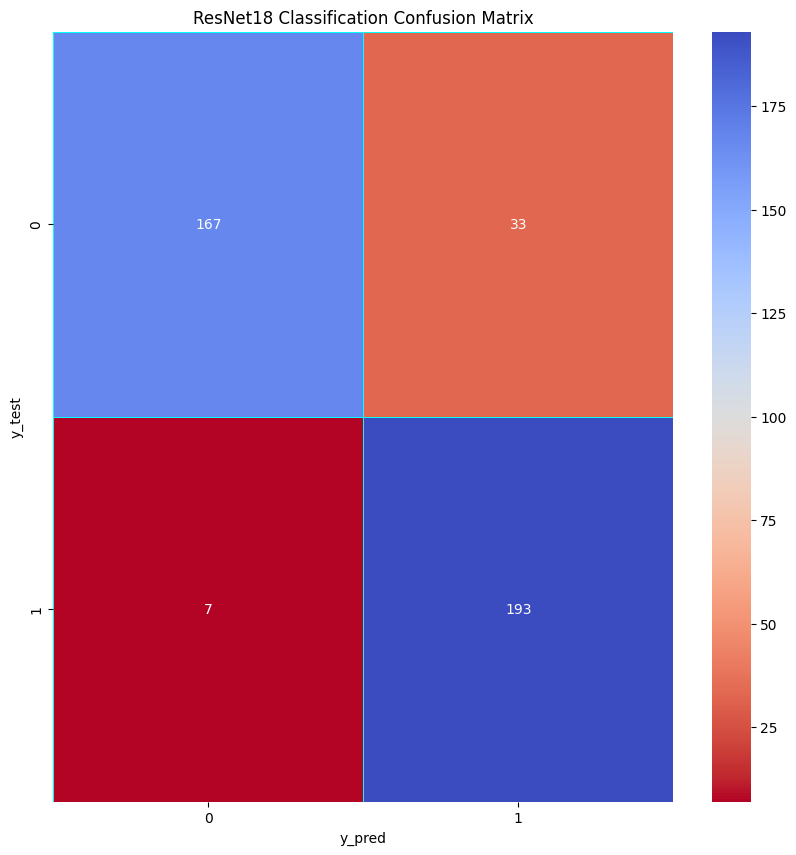

In [ ]:
# Creating the confusion matrix:
e_cm = confusion_matrix(actual_labels, preds)
# Visualization:
f, ax = plt.subplots(figsize=(10,10))
sns.heatmap(e_cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='.0f', ax=ax, cmap='coolwarm_r')
plt.title('Coral Classification Confusion Matrix')
plt.xlabel('y_pred')
plt.ylabel('y_test')
plt.show()

In [ ]:
print(classification_report(actual_labels, preds))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89       200
           1       0.85      0.96      0.91       200

    accuracy                           0.90       400
   macro avg       0.91      0.90      0.90       400
weighted avg       0.91      0.90      0.90       400

